# Almost Visual Inertial Odometry

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import MobileNetV2, mobilenet_v3_small, MobileNet_V3_Small_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
from  matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Constants

In [2]:
SEED = 20197
BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
GAMMA = 0.1   # torch default
LR=0.001 
EPOCHS = 10

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device

In [4]:
available_cuda = torch.cuda.is_available()
print(f"Available cuda: {available_cuda}")

device = torch.device("cuda" if available_cuda else "cpu")

Available cuda: True


# Dataset

In [5]:
class AdvioDataset(torch.utils.data.Dataset):
      def __init__(self, frames, inertials, labels, inertials_buffer, choose_split=None, split={'train':0.6, 'val':0.2, 'test':0.2}):
            if choose_split is None:
                  self.frames = frames
                  self.inertials = inertials
                  self.labels = labels
                  self.inertials_buffer = inertials_buffer
            else:
                  assert split['train'] + split['val'] + split['test'] == 1
                  length = frames.shape[0]
                  if choose_split == "train":
                        self.frames = frames[:round(split['train']*length)]
                        self.inertials = inertials[:round(split['train']*length)]
                        self.labels = labels[:round(split['train']*length)]
                        self.inertials_buffer = inertials_buffer[:round(split['train']*length)]
                  elif choose_split == "val":
                        self.frames = frames[round(split['train']*length):-round(split['test']*length)]
                        self.inertials = inertials[round(split['train']*length):-round(split['test']*length)]
                        self.labels = labels[round(split['train']*length):-round(split['test']*length)]
                        self.inertials_buffer = inertials_buffer[round(split['train']*length):-round(split['test']*length)]
                  elif choose_split == "test":
                        self.frames = frames[-round(split['test']*length):]
                        self.inertials = inertials[-round(split['test']*length):]
                        self.labels = labels[-round(split['test']*length):]
                        self.inertials_buffer = inertials_buffer[-round(split['test']*length):]
                  else:
                        raise Exception(f"The split name '{choose_split}' doesn't exists")

      def __len__(self):
            return len(self.frames) - 1

      def __getitem__(self, index):
            # load sample of frames
            sample_frame = self.frames[index + 1] - self.frames[index]
            sample_frame = torch.moveaxis(sample_frame, -1, 0)

            # build buffer sample of inertials
            sample_inertials_buffer = self.inertials_buffer[index + 1]

            # load labels
            label_odometry = self.labels[index + 1]

            # load inertials
            label_inertial = self.inertials[index + 1]

            return sample_frame, sample_inertials_buffer, label_odometry, label_inertial


frames = torch.Tensor(np.load("./data/advio-01/iphone/frames.npy"))
inertials = torch.Tensor(np.load("./data/advio-01/iphone/inertials.npy"))
labels = torch.Tensor(np.load("./data/advio-01/iphone/labels.npy"))
buffer_inertials = torch.Tensor(np.load("./data/advio-01/iphone/inertial_buffer.npy"))

train_data = AdvioDataset(frames, inertials, labels, buffer_inertials, "train")
val_data = AdvioDataset(frames, inertials, labels, buffer_inertials, "val")
test_data = AdvioDataset(frames, inertials, labels, buffer_inertials, "test")

del frames
del inertials
del labels
del buffer_inertials

params = {'batch_size': BATCH_SIZE,
          'num_workers': 6,
          'drop_last':True}
train_loader = DataLoader(train_data, **params, shuffle=True)
val_loader = DataLoader(val_data, **params, shuffle=True)
test_loader = DataLoader(test_data, **params)

# Model

In [6]:
class ConvNet1D(nn.Module):
  def __init__(self):
    super(ConvNet1D,self).__init__()
    self.conv1 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv1.weight)
    
    self.conv2 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv2.weight)
    
    self.conv3 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv3.weight)
    
    self.conv4 = nn.Conv1d(3,3,3,2)
    torch.nn.init.kaiming_uniform_(self.conv4.weight)
    
    self.conv5 = nn.Conv1d(3,3,3,1)
    torch.nn.init.kaiming_uniform_(self.conv5.weight)

    self.conv6 = nn.Conv1d(3,3,3,1)
    torch.nn.init.kaiming_uniform_(self.conv6.weight)

    self.fc1 = nn.Linear(3,3)

  def forward(self,x):
    # adding uncertanty
    # random_weights = torch.randn(x.shape)*2 + 1
    # random_weights = random_weights.to(device)
    # x = x * random_weights

    x = F.silu(self.conv1(x))
    x = F.silu(self.conv2(x))
    x = F.silu(self.conv3(x))
    x = F.silu(self.conv4(x))
    x = F.silu(self.conv5(x))
    x = F.silu(self.conv6(x))
    x = x.reshape(x.shape[0], 3)
    x = self.fc1(x)
    
    return x

In [7]:
class InertialNet(nn.Module):
    def __init__(self):
        super(InertialNet, self).__init__()
        
        self.conv2d_odometry = MobileNetV2(num_classes=3)
        self.conv2d_inertial = MobileNetV2(num_classes=3)
        self.conv1d_inertial = ConvNet1D()

        self.fc1 = nn.Linear(6,6)
        self.fc2 = nn.Linear(6,3)
        self.fc3 = nn.Linear(3,3)

    def forward(self, x, inertial_buffer):
        x_odometry = self.conv2d_odometry(x)
        x_inertial = self.conv2d_inertial(x)

        x_inertial_unsqueezed = torch.unsqueeze(x_inertial, axis=2)
        x_inertial_buffer = torch.concat([inertial_buffer, x_inertial_unsqueezed], axis=2)
        x_inertial_refined = self.conv1d_inertial(x_inertial_buffer)

        x_odometry = x_odometry.reshape((x.shape[0], -1))
        x_inertial_refined = x_inertial_refined.reshape((x.shape[0], -1))
        x = torch.concat([x_odometry, x_inertial_refined], axis=1)

        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = self.fc3(x)

        return x, x_inertial, x_inertial_refined

In [8]:
def replace_head(model):
    n_inputs = model.classifier[0].in_features
    classifier = nn.Linear(n_inputs, 100)
    model.classifier[0] = classifier

    n_inputs = model.classifier[3].in_features
    classifier = nn.Linear(100, 3)
    model.classifier[3] = classifier
    return model

In [9]:
class InertialNet2(nn.Module):
    def __init__(self):
        super(InertialNet2, self).__init__()
        
        self.conv2d_odometry = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.conv2d_odometry = replace_head(self.conv2d_odometry)
        self.conv2d_inertial = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.conv2d_odometry = replace_head(self.conv2d_inertial)
        self.conv1d_inertial = ConvNet1D()

        self.fc1 = nn.Linear(6,6)
        self.fc2 = nn.Linear(6,3)
        self.fc3 = nn.Linear(3,3)

    def forward(self, x, inertial_buffer):
        x_odometry = self.conv2d_odometry(x)
        x_inertial = self.conv2d_inertial(x)

        x_inertial_unsqueezed = torch.unsqueeze(x_inertial, axis=2)
        x_inertial_buffer = torch.concat([inertial_buffer, x_inertial_unsqueezed], axis=2)
        x_inertial_refined = self.conv1d_inertial(x_inertial_buffer)

        x_odometry = x_odometry.reshape((x.shape[0], -1))
        x_inertial_refined = x_inertial_refined.reshape((x.shape[0], -1))
        x = torch.concat([x_odometry, x_inertial_refined], axis=1)

        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = self.fc3(x)

        return x, x_inertial, x_inertial_refined

# Training

In [10]:
def normalize(data):
  data = data - data.min()
  data = data / data.max()
  return data

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    history_loss = 0
    history_loss=0
    history_odometry_loss=0
    history_inertial_loss=0
    history_inertial_refined_loss=0

    for batch_idx, (data, inertials_buffer, labels_odometry, labels_inertial) in enumerate(train_loader):
        # data preparation
        data = normalize(data)
        labels_odometry = labels_odometry.mean(axis=1)
        inertials_buffer = inertials_buffer.mean(axis=2)
        inertials_buffer = torch.moveaxis(inertials_buffer, 2, 1)
        labels_inertial = labels_inertial.mean(axis=1)

        data = data.to(device)
        inertials_buffer = inertials_buffer.to(device)
        labels_odometry = labels_odometry.to(device)
        labels_inertial = labels_inertial.to(device)

        #forward
        optimizer.zero_grad()
        out, out_inertial, out_inertial_refined = model(data, inertials_buffer)

        # loss
        odometry_loss = F.mse_loss(out, labels_odometry)
        inertial_loss = F.mse_loss(out_inertial, labels_inertial)
        inertial_refined_loss = F.mse_loss(out_inertial_refined, labels_inertial)
        loss = odometry_loss + inertial_loss + inertial_refined_loss

        # backward
        loss.backward()
        optimizer.step()

        #stats
        history_loss += loss.item()
        history_odometry_loss += odometry_loss.item()
        history_inertial_loss += inertial_loss.item()
        history_inertial_refined_loss += inertial_refined_loss.item()

        if batch_idx%60==0:
            print(f"\t[# {batch_idx: 4}] train_loss: {loss.item():.6f}, odo_loss: {odometry_loss.item():.6f}, ine_loss: {inertial_loss.item():.6f}, ref_loss: {inertial_refined_loss.item():.6f}")
    
    history_loss /= len(train_loader) # average epoch loss
    history_odometry_loss /= len(train_loader)
    history_inertial_loss /= len(train_loader)
    history_inertial_refined_loss /= len(train_loader)
    
    return history_loss, history_odometry_loss, history_inertial_loss, history_inertial_refined_loss


In [15]:
def validation(model, device, val_loader, epoch):
    model.train()
    history_loss=0
    history_odometry_loss=0
    history_inertial_loss=0
    history_inertial_refined_loss=0

    for batch_idx, (data, inertials_buffer, labels_odometry, labels_inertial) in enumerate(val_loader):
        # data preparation
        data = normalize(data)
        labels_odometry = labels_odometry.mean(axis=1)
        inertials_buffer = inertials_buffer.mean(axis=2)
        inertials_buffer = torch.moveaxis(inertials_buffer, 2, 1)
        labels_inertial = labels_inertial.mean(axis=1)

        data = data.to(device)
        inertials_buffer = inertials_buffer.to(device)
        labels_odometry = labels_odometry.to(device)
        labels_inertial = labels_inertial.to(device)

        # forward
        out, out_inertial, out_inertial_refined = model(data, inertials_buffer)

        # loss
        odometry_loss = F.mse_loss(out, labels_odometry)
        inertial_loss = F.mse_loss(out_inertial, labels_inertial)
        inertial_refined_loss = F.mse_loss(out_inertial_refined, labels_inertial)
        loss = odometry_loss + inertial_loss + inertial_refined_loss
        
        #stats
        history_loss += loss.item()
        history_odometry_loss += odometry_loss.item()
        history_inertial_loss += inertial_loss.item()
        history_inertial_refined_loss += inertial_refined_loss.item()

    history_loss /= len(val_loader) # average epoch loss
    history_odometry_loss /= len(val_loader)
    history_inertial_loss /= len(val_loader)
    history_inertial_refined_loss /= len(val_loader)
    print(f"\tval_loss: {history_loss:.6f}, odo_loss: {history_odometry_loss:.6f}, ine_loss: {history_inertial_loss:.6f}, ref_loss: {history_inertial_refined_loss:.6f}")

    return history_loss, history_odometry_loss, history_inertial_loss, history_inertial_refined_loss


In [16]:
model = InertialNet2().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

h_loss_train = []
h_loss_val = []

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")

    _, loss_train, _, _ = train(model, device, train_loader, optimizer, epoch)
    _, loss_val, _, _ = validation(model, device, val_loader, epoch)

    #populating the history of the loss
    h_loss_train.append(loss_train)
    h_loss_val.append(loss_val)

np.savez(f"train_loss_{EPOCHS}", h_loss_train)
np.savez(f"val_loss_{EPOCHS}", h_loss_val)


Epoch 1/10
	[#    0] train_loss: 87.442520, odo_loss: 86.727951, ine_loss: 0.367918, ref_loss: 0.346648
	[#   60] train_loss: 49.188377, odo_loss: 48.863506, ine_loss: 0.076909, ref_loss: 0.247963
	[#  120] train_loss: 67.767326, odo_loss: 67.575729, ine_loss: 0.070057, ref_loss: 0.121542
	[#  180] train_loss: 68.781052, odo_loss: 68.629700, ine_loss: 0.076824, ref_loss: 0.074530
	[#  240] train_loss: 54.709644, odo_loss: 54.658020, ine_loss: 0.027394, ref_loss: 0.024231
	[#  300] train_loss: 51.197273, odo_loss: 51.009377, ine_loss: 0.086300, ref_loss: 0.101597
	[#  360] train_loss: 52.108677, odo_loss: 52.015945, ine_loss: 0.033561, ref_loss: 0.059169
	[#  420] train_loss: 59.116909, odo_loss: 58.981274, ine_loss: 0.054052, ref_loss: 0.081585
	[#  480] train_loss: 49.344303, odo_loss: 49.270321, ine_loss: 0.039034, ref_loss: 0.034948
	val_loss: 122.202701, odo_loss: 122.075067, ine_loss: 0.068498, ref_loss: 0.059136
Epoch 2/10
	[#    0] train_loss: 65.865120, odo_loss: 65.799072, ine

# Plotting

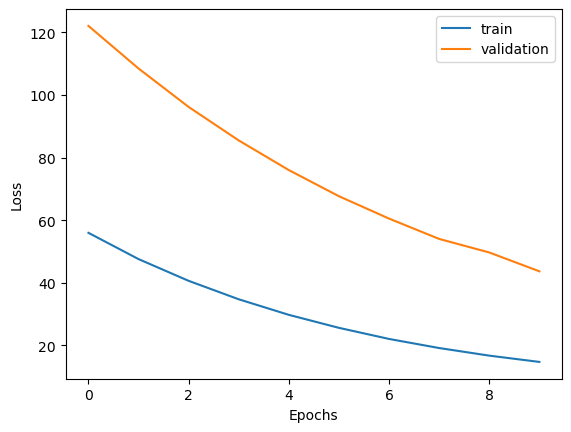

In [23]:
plt.plot(h_loss_train, label="train")
plt.plot(h_loss_val, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

### Zoomed plot (last 30 epochs)

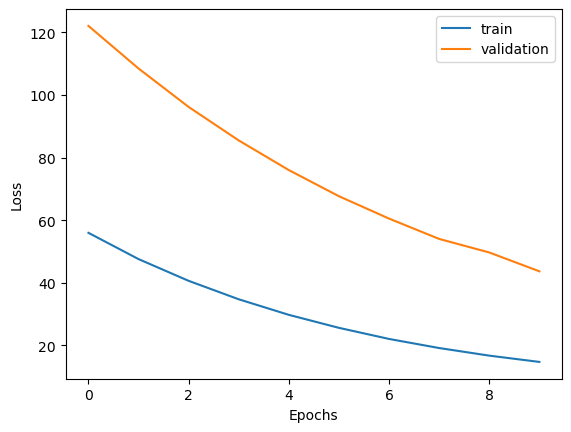

In [19]:
plt.plot(np.array(h_loss_train)[-30:], label="train")
plt.plot(np.array(h_loss_val)[-30:], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

## Trajectory plot

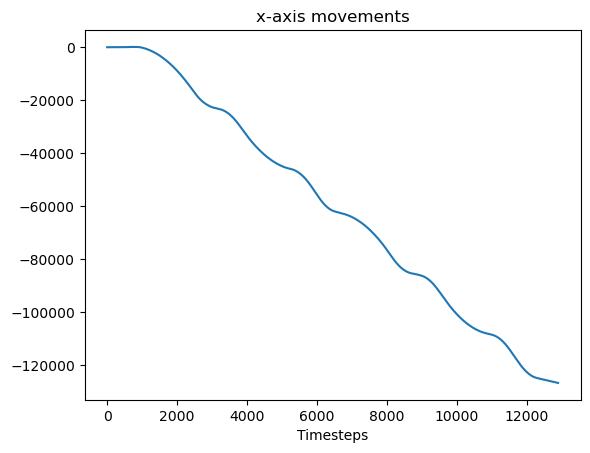

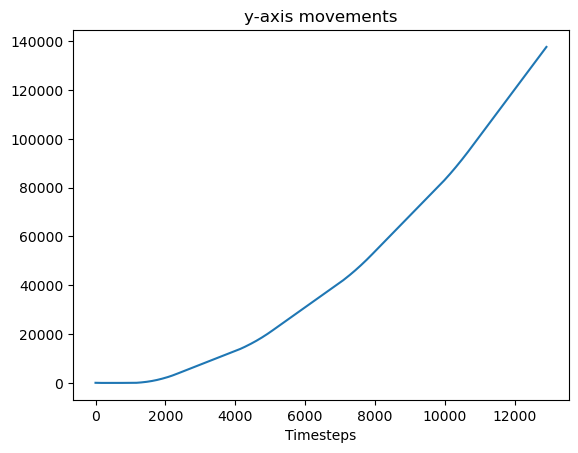

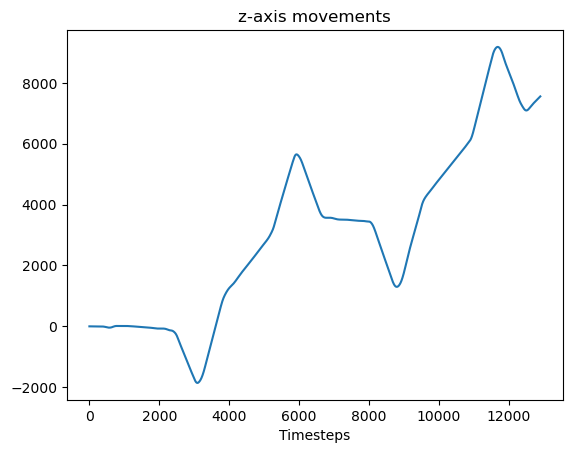

In [22]:
data = np.load("./data/advio-01/iphone/labels.npy")
data = data.mean(axis=1)
route = np.zeros(data.shape)
current_point = np.array([0, 0, 0]).astype(np.float32)

for idx, delta in enumerate(data):
    delta = delta.astype(np.float32)
    #print(f"({current_point.shape}) {current_point} - ({delta.shape}) {delta}")
    current_point += delta
    route[idx, :] = current_point

plt.title("x-axis movements")
plt.xlabel("Timesteps")
plt.plot(route[:, 0])
plt.show()

plt.title("y-axis movements")
plt.xlabel("Timesteps")
plt.plot(route[:, 1])
plt.show()

plt.title("z-axis movements")
plt.xlabel("Timesteps")
plt.plot(route[:, 2])
plt.show()